## Pix2Pix Google Maps

In [1]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz

--2020-06-21 13:34:53--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M   105MB/s    in 2.3s    

2020-06-21 13:34:55 (105 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [2]:
!tar -xvzf maps.tar.gz

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531.jpg
maps/train/532.jpg
maps/train/533.jpg
maps/train/534.jpg
maps/train/535.jpg
maps/train/536.jpg
maps/train/537.jpg
maps/train/538.jpg
maps/train/539.jpg
maps/train/54.jpg
maps/train/540.jpg
maps/train/541.jpg
maps/train/542.jpg
maps/train/543.jpg
maps/train/544.jpg
maps/train/545.jpg
maps/train/546.jpg
maps/train/547.jpg
maps/train/548.jpg
maps/train/549.jpg
maps/train/55.jpg
maps/train/550.jpg
maps/train/551.jpg
maps/train/552.jpg
maps/train/553.jpg
maps/train/554.jpg
maps/train/555.jpg
maps/train/556.jpg
maps/train/557.jpg
maps/train/558.jpg
ma

In [3]:
!rm maps.tar.gz

In [4]:
from PIL import Image
import h5py
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
%matplotlib inline

import torch
from torch import nn
from torch.utils import data
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset, dataloader

In [5]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
train_images = list()
for file_name in tqdm(sorted(os.listdir('maps/train'))):
  img = Image.open(os.path.join(f'maps/train/{file_name}'))
  input_image = img.crop((0, 0, img.width // 2, img.height))
  target_image = img.crop((img.width // 2, 0, img.width, img.height))
  train_images.append([transform(input_image), transform(target_image)])

In [6]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
val_images = list()
for file_name in tqdm(sorted(os.listdir('maps/val'))):
  img = Image.open(os.path.join(f'maps/val/{file_name}'))
  input_image = img.crop((0, 0, img.width // 2, img.height))
  target_image = img.crop((img.width // 2, 0, img.width, img.height))
  val_images.append([transform(input_image), transform(target_image)])

In [7]:
class ImageDataset(data.Dataset):
    def __init__(self, images, map_to_satel=True):
        super().__init__()
        self.images = images
        self.map_to_satel = map_to_satel
        
    def __getitem__(self, index):
      satel_image, map_image = self.images[index]
      if self.map_to_satel:
        return map_image, satel_image
      else:
        return satel_image, map_image

    def __len__(self):
        return len(self.images)

In [8]:
train_dataset = ImageDataset(train_images, map_to_satel=False)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = ImageDataset(val_images, map_to_satel=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False, num_workers=1)

### Дискриминатор

In [37]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU()
        )

        self.conv6 = nn.Conv2d(512, 1, kernel_size=1)
        

    def forward(self, x, label):
        x = torch.cat([x, label], dim=1)
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        out = torch.nn.Sigmoid()(x)
        return out

### Генератор

In [10]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    # encoder (downsampling)
    self.enc_conv0 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU()
    )
    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=1),
        nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU()
    )
    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=2, stride=2, padding=1),
        nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU()
    )
    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(256,256, kernel_size=2, stride=2, padding=1),
        nn.Conv2d(256, 512, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU()
    )
    self.bottleneck = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=2, stride=2, padding=1),
        nn.Conv2d(512, 1024, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(),
        nn.Conv2d(1024, 512, kernel_size=2, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU()
    )

    # decoder
    self.upsample3 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2, padding=3, output_padding=1)
    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(1024, 512, kernel_size=2,  padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    ) 
    self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=3, output_padding=1)
    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=2, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    ) 
    self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=3)
    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    ) 
    self.upsample0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=3)
    self.dec_conv0 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 3, kernel_size=1)
    )

  def forward(self, x):
    e0 = self.enc_conv0(x)
    e1 = self.enc_conv1(e0)
    e2 = self.enc_conv2(e1)
    e3 = self.enc_conv3(e2)

    b = self.bottleneck(e3)
    # decoder
    d3 = self.upsample3(b)
    d3 = torch.cat((d3, e3), dim=1)
    d2 = self.dec_conv3(d3)

    d2 = self.upsample2(d2)
    d2 = torch.cat((d2, e2), dim=1)
    d1 = self.dec_conv2(d2)

    d1 = self.upsample1(d1)
    d1 = torch.cat((d1, e1), dim=1)
    d0 = self.dec_conv1(d1)

    d0 = self.upsample0(d0)
    d0 = torch.cat((d0, e0), dim=1)
    res = self.dec_conv0(d0) 
    return torch.nn.Tanh()(res)

In [11]:
from torchsummary import summary
summary(Generator().to(device), (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 129, 129]          16,448
            Conv2d-5        [-1, 128, 130, 130]          32,896
       BatchNorm2d-6        [-1, 128, 130, 130]             256
         LeakyReLU-7        [-1, 128, 130, 130]               0
            Conv2d-8          [-1, 128, 66, 66]          65,664
            Conv2d-9          [-1, 256, 67, 67]         131,328
      BatchNorm2d-10          [-1, 256, 67, 67]             512
        LeakyReLU-11          [-1, 256, 67, 67]               0
           Conv2d-12          [-1, 256, 34, 34]         262,400
           Conv2d-13          [-1, 512, 35, 35]         524,800
      BatchNorm2d-14          [-1, 512,

### Функция обучения

In [12]:
def train(G, D, G_optimizer, D_optimizer, epoch_losses, num_epochs, val_step=100):
  G.train()
  D.train()

  out = Output()

  for epoch in tqdm(range(1, num_epochs + 1), desc='Эпоха'):
      D_loss_running, G_loss_running = 0.0, 0.0
      fig = None

      for i, (input_image, target_image) in enumerate(tqdm(train_loader, desc='Изображений обработано')):
          input_image = input_image.to(device)
          target = target_image.to(device)

          # Train discriminator with real data
          D_real_decision = D(input_image, target).squeeze()
          real_ = torch.ones(D_real_decision.size()).to(device)
          D_real_loss = BCE_loss(D_real_decision, real_)

          # Train discriminator with fake data
          gen_image = G(input_image)
          D_fake_decision = D(input_image, gen_image).squeeze()
          fake_ = torch.zeros(D_fake_decision.size()).to(device)
          D_fake_loss = BCE_loss(D_fake_decision, fake_)

          # Back propagation
          D_loss = (D_real_loss + D_fake_loss) * 0.5
          D_optimizer.zero_grad()
          D_loss.backward()
          D_optimizer.step()

          # Train generator
          gen_image = G(input_image)
          D_fake_decision = D(input_image, gen_image).squeeze()
          G_fake_loss = BCE_loss(D_fake_decision, real_)

          # L1 loss
          l1_loss_value = 100 * L1_loss(gen_image, target)

          # Back propagation
          G_loss = G_fake_loss + l1_loss_value
          G_optimizer.zero_grad()
          G_loss.backward()
          G_optimizer.step()

          # loss values
          D_loss_running += D_loss.item()
          G_loss_running += G_loss.item()

          if (i + 1) % val_step == 0:
            G.eval()
            val_image, val_target = val_dataset[random.randint(0, len(val_dataset)-1)]
            with torch.no_grad():
              gen_image = G(val_image.unsqueeze(0).to(device))

            gen_image = gen_image.detach().cpu()

            # print input, generated and true images
            with out:
              clear_output()
            out = Output()
            display(out)
            with out:
              plot_val(val_image, gen_image, val_target)

            G.train()

      D_loss_epoch = D_loss_running / len(train_loader)
      G_loss_epoch = G_loss_running / len(train_loader)
      print(f"Эпоха {epoch}/{num_epochs}: Disc loss={D_loss_epoch:.4f}, Gen loss={G_loss_epoch:.4f}")


      # avg loss values for plot
      epoch_losses['Disc'].append(D_loss_running / len(train_loader))
      epoch_losses['Gen'].append(G_loss_running / len(train_loader))

In [13]:
from ipywidgets import Output
from IPython.display import clear_output
import numpy as np

In [14]:
def unnorm_img(img):
  img = (((img[0] - img[0].min()) * 255) / (img[0].max() - img[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
  return img

def plot_val(val_image, gen_image, val_target):
  fig, axs = plt.subplots(1, 3)
  fig.set_figheight(10)
  fig.set_figwidth(10)

  val_image = unnorm_img(val_image.unsqueeze(0))
  gen_image = unnorm_img(gen_image)
  val_target = unnorm_img(val_target.unsqueeze(0))
  axs[0].imshow(val_image, cmap=None)
  axs[0].set_title('Input', fontsize=16)
  axs[0].axis('off')
  axs[1].imshow(gen_image, cmap=None)
  axs[1].set_title('Generated', fontsize=16)
  axs[1].axis('off')
  axs[2].imshow(val_target, cmap=None)
  axs[2].set_title('Target', fontsize=16)
  axs[2].axis('off')
  fig.tight_layout()
  plt.show()

### Обучение

In [38]:
BCE_loss = torch.nn.BCELoss()
L1_loss = torch.nn.L1Loss()

G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

num_epochs = 50
epoch_losses = {'Disc':[], 'Gen':[]}

In [39]:
train(G, D, G_optimizer, D_optimizer, epoch_losses, num_epochs, val_step=200)

Output()

Output()

Output()

Output()

Output()


Эпоха 1/50: Disc loss=0.4836, Gen loss=15.3527


Output()

Output()

Output()

Output()

Output()


Эпоха 2/50: Disc loss=0.5300, Gen loss=11.4572


Output()

Output()

Output()

Output()

Output()


Эпоха 3/50: Disc loss=0.4873, Gen loss=11.6436


Output()

Output()

Output()

Output()

Output()


Эпоха 4/50: Disc loss=0.4583, Gen loss=13.2200


Output()

Output()

Output()

Output()

Output()


Эпоха 5/50: Disc loss=0.4573, Gen loss=11.6420


Output()

Output()

Output()

Output()

Output()


Эпоха 6/50: Disc loss=0.4947, Gen loss=10.7573


Output()

Output()

Output()

Output()

Output()


Эпоха 7/50: Disc loss=0.4031, Gen loss=11.1883


Output()

Output()

Output()

Output()

Output()


Эпоха 8/50: Disc loss=0.4128, Gen loss=10.8038


Output()

Output()

Output()

Output()

Output()


Эпоха 9/50: Disc loss=0.3871, Gen loss=11.6600


Output()

Output()

Output()

Output()

Output()


Эпоха 10/50: Disc loss=0.4248, Gen loss=11.3799


Output()

Output()

Output()

Output()

Output()


Эпоха 11/50: Disc loss=0.4432, Gen loss=10.2035


Output()

Output()

Output()

Output()

Output()


Эпоха 12/50: Disc loss=0.4310, Gen loss=10.5101


Output()

Output()

Output()

Output()

Output()


Эпоха 13/50: Disc loss=0.4102, Gen loss=10.6469


Output()

Output()

Output()

Output()

Output()


Эпоха 14/50: Disc loss=0.4143, Gen loss=10.1769


Output()

Output()

Output()

Output()

Output()


Эпоха 15/50: Disc loss=0.3840, Gen loss=10.6036


Output()

Output()

Output()

Output()

Output()


Эпоха 16/50: Disc loss=0.3766, Gen loss=10.4725


Output()

Output()

Output()

Output()

Output()


Эпоха 17/50: Disc loss=0.3657, Gen loss=10.4899


Output()

Output()

Output()

Output()

Output()


Эпоха 18/50: Disc loss=0.3515, Gen loss=10.9869


Output()

Output()

Output()

Output()

Output()


Эпоха 19/50: Disc loss=0.3337, Gen loss=11.0962


Output()

Output()

Output()

Output()

Output()


Эпоха 20/50: Disc loss=0.3014, Gen loss=11.3125


Output()

Output()

Output()

Output()

Output()


Эпоха 21/50: Disc loss=0.3090, Gen loss=11.4164


Output()

Output()

Output()

Output()

Output()


Эпоха 22/50: Disc loss=0.2929, Gen loss=11.5582


Output()

Output()

Output()

Output()

Output()


Эпоха 23/50: Disc loss=0.3438, Gen loss=11.3869


Output()

Output()

Output()

Output()

Output()


Эпоха 24/50: Disc loss=0.2359, Gen loss=13.3838


Output()

Output()

Output()

Output()

Output()


Эпоха 25/50: Disc loss=0.2299, Gen loss=12.8081


Output()

Output()

Output()

Output()

Output()


Эпоха 26/50: Disc loss=0.2035, Gen loss=12.9698


Output()

Output()

Output()

Output()

Output()


Эпоха 27/50: Disc loss=0.1936, Gen loss=13.6916


Output()

Output()

Output()

Output()

Output()


Эпоха 28/50: Disc loss=0.2255, Gen loss=13.0999


Output()

Output()

Output()

Output()

Output()


Эпоха 29/50: Disc loss=0.2172, Gen loss=12.6897


Output()

Output()

Output()

Output()

Output()


Эпоха 30/50: Disc loss=0.1871, Gen loss=13.6287


Output()

Output()

Output()

Output()

Output()


Эпоха 31/50: Disc loss=0.1740, Gen loss=14.0677


Output()

Output()

Output()

Output()

Output()


Эпоха 32/50: Disc loss=0.1652, Gen loss=14.1002


Output()

Output()

Output()

Output()

Output()


Эпоха 33/50: Disc loss=0.1673, Gen loss=14.7117


Output()

Output()

Output()

Output()

Output()


Эпоха 34/50: Disc loss=0.1850, Gen loss=14.9527


Output()

Output()

Output()

Output()

Output()


Эпоха 35/50: Disc loss=0.1603, Gen loss=14.7232


Output()

Output()

Output()

Output()

Output()


Эпоха 36/50: Disc loss=0.1537, Gen loss=15.0439


Output()

Output()

Output()

Output()

Output()


Эпоха 37/50: Disc loss=0.1451, Gen loss=15.2959


Output()

Output()

Output()

Output()

Output()


Эпоха 38/50: Disc loss=0.1475, Gen loss=15.1902


Output()

Output()

Output()

Output()

Output()


Эпоха 39/50: Disc loss=0.1504, Gen loss=14.8611


Output()

Output()

Output()

Output()

Output()


Эпоха 40/50: Disc loss=0.1237, Gen loss=15.7579


Output()

Output()

Output()

Output()

Output()


Эпоха 41/50: Disc loss=0.1331, Gen loss=15.3385


Output()

Output()

Output()

Output()

Output()


Эпоха 42/50: Disc loss=0.1482, Gen loss=14.6056


Output()

Output()

Output()

Output()

Output()


Эпоха 43/50: Disc loss=0.1376, Gen loss=14.5122


Output()

Output()

Output()

Output()

Output()


Эпоха 44/50: Disc loss=0.1038, Gen loss=17.5801


Output()

Output()

Output()

Output()

Output()


Эпоха 45/50: Disc loss=0.1275, Gen loss=15.1613


Output()

Output()

Output()

Output()

Output()


Эпоха 46/50: Disc loss=0.1185, Gen loss=16.3345


Output()

Output()

Output()

Output()

Output()


Эпоха 47/50: Disc loss=0.1235, Gen loss=16.1110


Output()

Output()

Output()

Output()

Output()


Эпоха 48/50: Disc loss=0.0997, Gen loss=19.7990


Output()

Output()

Output()

Output()

Output()


Эпоха 49/50: Disc loss=0.1115, Gen loss=15.6925


Output()

Output()

Output()

Output()

Output()


Эпоха 50/50: Disc loss=0.1365, Gen loss=15.1022



In [40]:
torch.save(G.state_dict(), 'gen_50epochs.pth')
torch.save(D.state_dict(), 'disc_50epochs.pth')

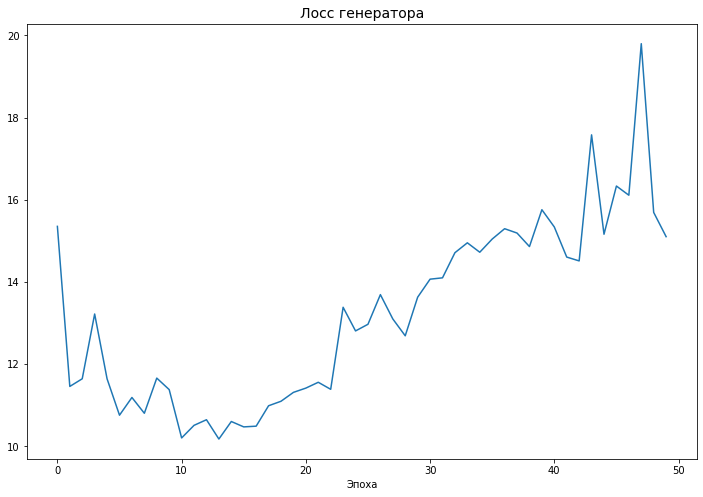

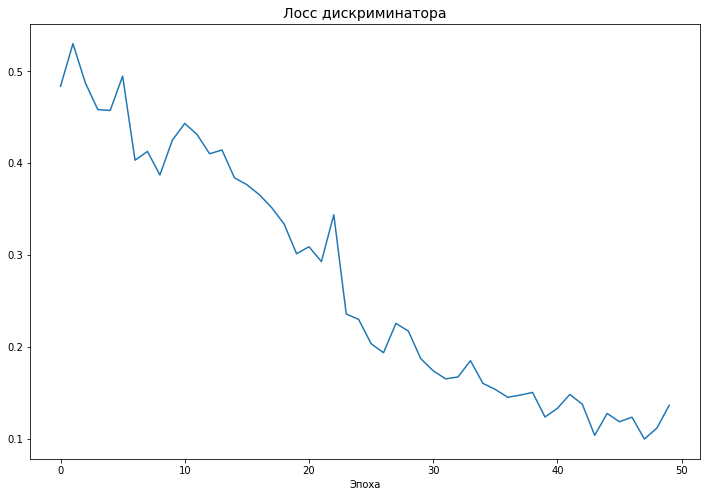

In [41]:
plt.figure(figsize=(12, 8))
plt.title('Лосс генератора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Gen'])
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Лосс дискриминатора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Disc'])
plt.show()

Дообучим еще 50 эпох

In [ ]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

num_epochs = 50
train(G, D, G_optimizer, D_optimizer, epoch_losses, num_epochs, val_step=500)

In [ ]:
torch.save(G.state_dict(), 'gen_100epochs.pth')
torch.save(D.state_dict(), 'disc_100epochs.pth')

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Лосс генератора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Gen'])
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Лосс дискриминатора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Disc'])
plt.show()

Дообучим еще 100 эпох

In [ ]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=5e-5, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=5e-5, betas=(0.5, 0.999))

num_epochs = 100
train(G, D, G_optimizer, D_optimizer, epoch_losses, num_epochs, val_step=500)

In [ ]:
torch.save(G.state_dict(), 'gen_200epochs.pth')
torch.save(D.state_dict(), 'disc_200epochs.pth')

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Лосс генератора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Gen'])
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Лосс дискриминатора', fontsize=14)
plt.xlabel('Эпоха')
plt.plot(epoch_losses['Disc'])
plt.show()

### Посмотрим на результат на нескольких изображениях из валидационной выборки

In [ ]:
G.load_state_dict(torch.load('gen_50epochs.pth'))

<All keys matched successfully>

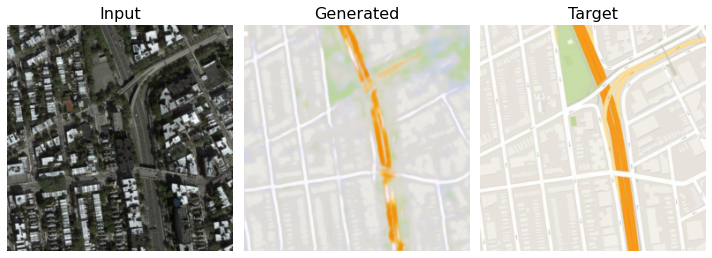

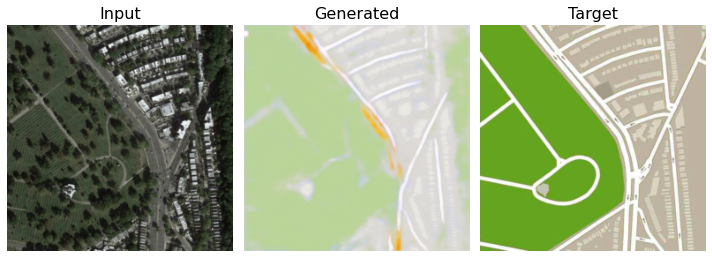

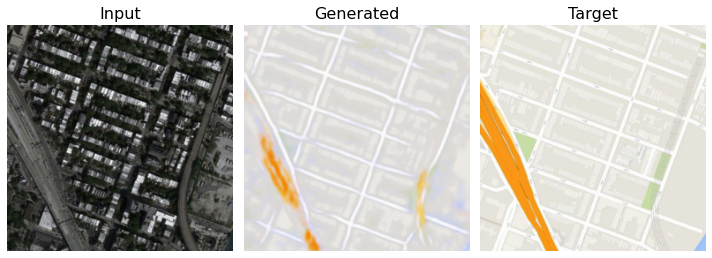

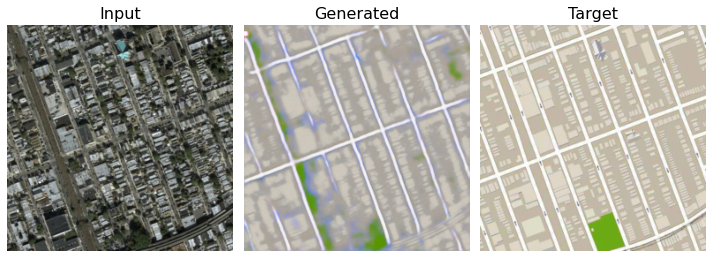

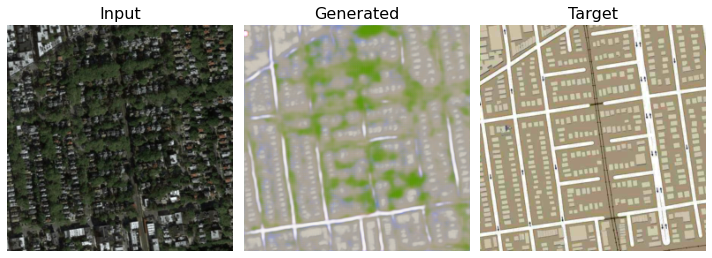

In [ ]:
G.eval()

for _ in range(5):
  val_image, val_target = val_dataset[random.randint(0, len(val_dataset)-1)]
  with torch.no_grad():
    gen_image = G(val_image.unsqueeze(0).to(device))

  gen_image = gen_image.detach().cpu()

  plot_val(val_image, gen_image, val_target)